In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import distance

In [66]:
class node:
    def __init__(self, x, y, xPre, yPre, dist=0, indPre=0):
        self.x = [x]
        self.y = [y]
        self.xPre = [xPre]
        self.yPre = [yPre]
        self.dist = [dist]
        self.indPre = [indPre]
        
class path:
    def __init__(self, x, y):
        self.x = [x]
        self.y = [y]

In [67]:
def sqrt_mse(front, back):
    return math.sqrt(2*((math.pow(front[0]-back[0], 2)) + math.pow(front[1]-back[1], 2)))

def line_check(axis1, axis2, gray_img):
    limit_range = 6
    if axis1[1] > axis2[1]:
        y_list = np.arange(int(axis2[1])-limit_range,int(axis1[1])+limit_range)
    elif axis1[1] < axis2[1]:
        y_list = np.arange(int(axis1[1])-limit_range, int(axis2[1])+limit_range)
    else:
        y_list = np.arange(int(axis1[1])-limit_range, int(axis1[1])+limit_range)
        
    if axis1[0] > axis2[0]:
        x_list = np.arange(int(axis2[0])-limit_range,int(axis1[0])+limit_range)
    elif axis1[0] < axis2[0]:
        x_list = np.arange(int(axis1[0])-limit_range, int(axis2[0])+limit_range)
    else:
        x_list = np.arange(int(axis1[0])-limit_range, int(axis1[0])+limit_range)
    
    for y in y_list:
        for x in x_list:
            gray_num = gray_img[y][x][0]
            if gray_num <= 205:
                return 1
    return 0

def check_in_boundary(axis, gray_img):
    limit_range = 6
    y_list = np.arange(int(axis[1])-limit_range, int(axis[1])+limit_range)
    x_list = np.arange(int(axis[0])-limit_range, int(axis[0])+limit_range)
    for y in y_list:
        for x in x_list:
            gray_num = gray_img[y][x][0]   
            if gray_num <= 205:
                return 1
    return 0

In [68]:
def PathRefine(robot, goal, path):
    pathLength = len(path.x)
    vector_x_pos = []
    vector_y_pos = []
    
    for i in range(pathLength):
        vector_x_pos.append(path.x[i])
        vector_y_pos.append(path.y[i])
    
    finalPath_refine = [vector_x_pos, vector_y_pos]
    distTable =  [[0]*pathLength]*pathLength
    
    for i in range(pathLength):
        for j in range(pathLength):
            A = math.pow(finalPath_refine[0][i] - finalPath_refine[0][j], 2)
            B = math.pow(finalPath_refine[1][i] - finalPath_refine[1][j], 2)
            MSE = (A + B) / 2
            distTable[i][j] = math.sqrt(2 * MSE) 
    
    startTag = pathLength - 1
    testTag = pathLength - 2
    refinePathTags = []
    refinePathTags.append(startTag)
    
    for i in range(50):
        if distTable[startTag][testTag-1] < (distTable[startTag][testTag] + distTable[testTag][testTag-1]):
            startTagPos = [finalPath_refine[0][startTag], finalPath_refine[1][startTag]]
            testTagPos = [finalPath_refine[0][testTag-1], finalPath_refine[1][testTag-1]]
            colTag = 0
            localColTag = []
            lineCheck = line_check(startTagPos, testTagPos, gray_img)
            
            if lineCheck == 1:
                colTag = 1

            if colTag == 1:
                refinePathTags.insert(0, testTag)
                startTag = testTag
                testTag = testTag - 1
            else:
                testTag = testTag - 1
            
            if testTag == 0:
                break
                
    refinePathTags.insert(0, 1)
    range_Num = len(refinePathTags)
    
    for j in range(range_Num-1):
        ax.plot([finalPath_refine[0][refinePathTags[j]], finalPath_refine[0][refinePathTags[j+1]]], [finalPath_refine[1][refinePathTags[j]], finalPath_refine[1][refinePathTags[j+1]]], 'k--', linewidth=1.5)
        ax.plot(finalPath_refine[0][j], finalPath_refine[1][j], 'ko', markersize=5, linewidth=1.5)  

    F_X = []
    F_Y = []
    for i in range(range_Num):
        F_X.append(finalPath_refine[0][refinePathTags[i]])
        F_Y.append(finalPath_refine[1][refinePathTags[i]])
    
    return [F_X, F_Y]

In [69]:
def RRT(node, path, start, end):
    for i in range(1, 3001):
        x_rand = [start[0] + (end[0]-start[0])* np.random.rand(1), start[1] + (end[1]-start[1])* np.random.rand(1)]
#        x_rand = [robot[0] + (goal[0]-robot[0])* np.random.rand(1), robot[1] + (goal[1]-robot[1])* np.random.rand(1)]
        
        min_dist = 9999999
        near_iter = 0
        N = len(node.x)
   
        for j in range(N):
            x_near = [node.x[j], node.y[j]]
            dist = distance.euclidean(x_rand, x_near)
            if min_dist > dist:
                min_dist = dist
                near_iter = j
            
        x_near = [node.x[near_iter], node.y[near_iter]]
        
        CheckInBoundNear = check_in_boundary(x_near, gray_img)
        
        if CheckInBoundNear == 1:
            continue
            
        near_rand = [x_rand[0]-x_near[0], x_rand[1]-x_near[1]]
        normlized = [near_rand[0] / distance.euclidean(x_rand, x_near)*stepsize, near_rand[1] / distance.euclidean(x_rand, x_near)*stepsize]
        x_new = [x_near[0] + normlized[0], x_near[1] + normlized[1]] 
        
        CheckInBoundNew = check_in_boundary(x_new, gray_img)
        
        if CheckInBoundNew == 1:
            continue
            
        ax.plot([x_near[0], x_new[0]], [x_near[1], x_new[1]], 'b-', linewidth=2)
        node.x.append(x_new[0])
        node.y.append(x_new[1])
        node.xPre.append(x_near[0])
        node.yPre.append(x_near[1])
        node.dist.append(distance.euclidean(x_new, x_near))
        node.indPre.append(near_iter)

        if distance.euclidean(x_new, end) < 5:
            break 

    if True:
        path.x[0] = end[0]
        path.y[0] = end[1]
        path.x.append(node.x[-1])
        path.y.append(node.y[-1])
        path_index = node.indPre[-1]

        while True:
            path.x.append(node.x[path_index])
            path.y.append(node.y[path_index])
            path_index = node.indPre[path_index]
            if path_index == 0:
                break

        path.x.append(start[0])
        path.y.append(start[1])
        Range_Num = len(path.x)
        for j in range(1, Range_Num):
            ax.plot([path.x[j], path.x[j-1]], [path.y[j], path.y[j-1]], 'r:', linewidth=2)

    else:
        print('no path to end')

In [70]:
stepsize = 5
robot = [320, 100]
robot_wd = 5
goal = [250, 280]
waypoint_1 = [350, 180]
waypoint_2 = [320, 250]

In [71]:
v = node(robot[0], robot[1], robot[0], robot[1])
v2 = node(waypoint_1[0], waypoint_1[1], waypoint_1[0], waypoint_1[1])
v3 = node(waypoint_2[0], waypoint_2[1], waypoint_2[0], waypoint_2[1])
pos = path(0, 0)
pos2 = path(0, 0)
pos3 = path(0, 0)

C:\Users\tjdgu\anaconda3\envs\tf\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\tjdgu\anaconda3\envs\tf\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\tjdgu\anaconda3\envs\tf\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of list

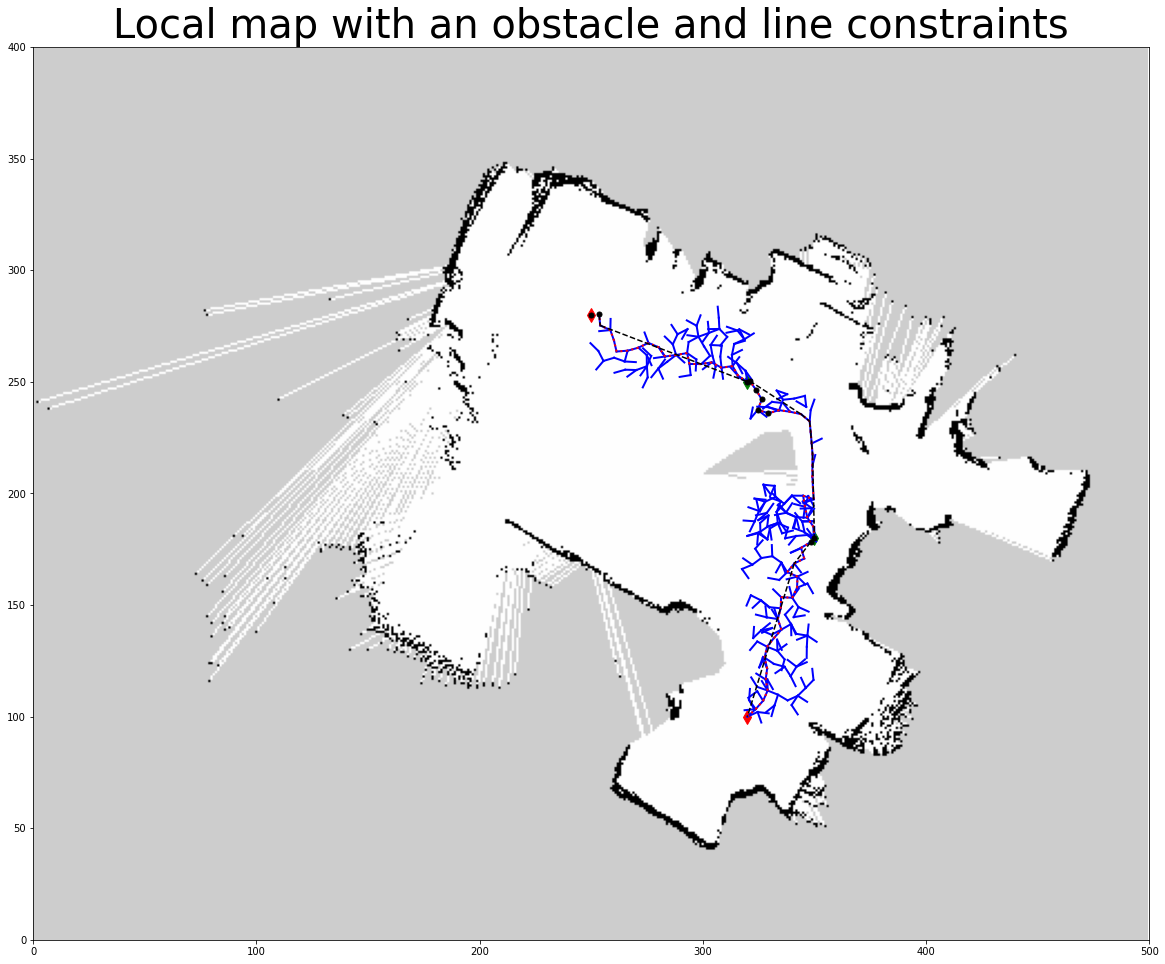

In [72]:
img = cv2.imread('lab.pgm')
img_cropped = img[250:650, 150:650]
gray_img = np.asarray(img_cropped)
gray = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2GRAY)
ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
binary = cv2.bitwise_not(binary)
   
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_title('Local map with an obstacle and line constraints', fontsize=40)

ax.set_xlim([0, 500])
ax.set_ylim([0, 400])
ax.plot(robot[0], robot[1], 'rd', markersize = 10, linewidth=3.5)
ax.plot(waypoint_1[0], waypoint_1[1], 'gd', markersize = 10, linewidth=2.5)
ax.plot(waypoint_2[0], waypoint_2[1], 'gd', markersize = 10, linewidth=2.5)
ax.plot(goal[0], goal[1], 'rd', markersize = 10, linewidth=3.5)

RRT(v, pos, robot, waypoint_1)
RRT(v2, pos2, waypoint_1, waypoint_2)
RRT(v3, pos3, waypoint_2, goal)

Final_1 = PathRefine(robot, waypoint_1, pos)
Final_2 = PathRefine(waypoint_1, waypoint_2, pos2)
Final_3 = PathRefine(waypoint_2, goal, pos3)
Add = []
Add.append(Final_3[0] + Final_2[0] + Final_1[0])
Add.append(Final_3[1] + Final_2[1] + Final_1[1])
number = []

rangenum = len(Add[0])-1
for i in range(rangenum):
    if Add[0][i] != Add[0][i+1] and Add[1][i] != Add[1][i+1]:
        number.append(i)

Add_x = []
Add_y = []
for j in number:
    Add_x.append(Add[0][j])
    Add_y.append(Add[1][j])

Add_x.insert(0,  goal[0])
Add_x.append(robot[0])
Add_y.insert(0, goal[1])
Add_y.append(robot[1])

Final_path = []
Final_path.append(Add_x)
Final_path.append(Add_y)

ax.imshow(img_cropped)